In [1]:
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from library.preprocessing import new_Processing_before_journal

# Getting Folders

In [2]:
all_folders=glob.glob("./Trails/*/*/")

test_dates=['2019-06-28','2019-06-30','2019-07-01','2019-07-02','2019-07-03','2019-07-04','2019-07-05']
formatted_test_dates=['-'.join(d.split("-")[::-1]) for d in test_dates] #reversing order

#train folders
train_folders=[f for f in all_folders if f.split("\\")[-2].split("_")[0] not in formatted_test_dates]

#test folders
test_folders=[f for f in all_folders if f.split("\\")[-2].split("_")[0] in formatted_test_dates]

# Loading Models

In [3]:
with open('./logs/rfs.pickle', 'rb') as handle:
    rfs = pickle.load(handle)

C:\Users\WER\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\WER\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:324: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Features

In [4]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }

selected_feat=\
    {
        'Is_Bus_stop':[F[e] for e in [10,12,11,1,8]],
        'Is_Turn':[F[e] for e in [10,12,11,1,8,9]],
        'Is_Signal':[F[e] for e in [12,11,10,8,9]],
        'Is_Congestion':[F[e] for e in [2,11,10,9,12,8,6,1]],
        'Is_Adhoc':[F[e] for e in [10,11,1,12,2]]
    }

# Processing Testing DATA

In [5]:
#test_folders

In [6]:
pred={}
we_need=['start_date','start_time','lat','long','stay_duration']+list(rfs.keys())

df= pd.concat([new_Processing_before_journal(folder+"ALL_DATA.csv") for folder in test_folders]).reset_index(drop=True)
for poi_column in rfs.keys():
    feature_names=selected_feat[poi_column]
    test_data = df[feature_names].values
    prediction=rfs[poi_column].predict_proba(test_data)
    pred[poi_column]=prediction

df_true=df[we_need].copy()

# AUC-ROC 

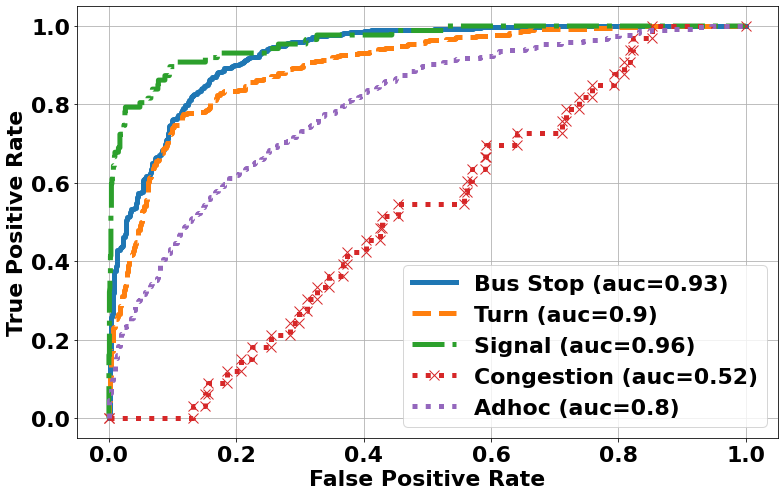

In [14]:
poi_columns=['Is_Bus_stop', 'Is_Turn', 'Is_Signal', 'Is_Congestion', 'Is_Adhoc']
labels=['Bus Stop','Turn','Signal','Congestion','Adhoc']
colors=sns.color_palette(n_colors=5)
linestyles=['-','--','-.',':',':']
markers=['','','','x','']

fig, ax = plt.subplots(figsize=(11,7))
for poi_column,c,ls,lbl,mkr in zip(poi_columns,colors,linestyles,labels,markers):
    fpr, tpr, _ =roc_curve(df_true[poi_column].values,pred[poi_column][:,1])
    auc =roc_auc_score(df_true[poi_column].values,pred[poi_column][:,1],average="weighted")
    ax.plot(fpr, tpr, c=c, linestyle=ls, label=lbl+f' (auc={round(auc,2)})',linewidth=5,marker=mkr,markersize=10)


ax.set_xlabel("False Positive Rate",fontsize=22, fontweight='bold')
ax.set_ylabel("True Positive Rate",fontsize=22, fontweight='bold')
ax.legend(loc='lower right',prop={'size':22,'weight':'bold'})
plt.xticks(fontsize=22, fontweight='bold')
plt.yticks(fontsize=22, fontweight='bold')
plt.tight_layout()
plt.grid()
#fig.savefig("./report/plots/roc_auc.png")

In [9]:
#NICE